In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import platform
import seaborn as sns
import os

In [130]:
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

print(platform.system()) # 플랫폼 확인

if platform.system() == 'Windows': # Window
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    matplotlib.rc('font', family='AppleGothic')

Darwin


In [131]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [132]:
folder = os.listdir()

file = []
for f in folder:
    if "jinju" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
# gajwa = gajwa.dropna(axis=0)

In [133]:
gajwa.도로조건.value_counts()

8m미만     1797
-        1581
12m미만    1454
25m미만     384
25m이상      55
Name: 도로조건, dtype: int64

In [134]:
geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})
gajwa = gajwa.fillna({'도로조건':gajwa['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
         a = "8"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)


gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735
3,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000
5,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5251,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972
5253,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500
5254,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660
5255,경상남도 진주시 호탄동,6**,8,50.00,전세,202011,18,9000,0,2018,호탄길9번길,128.105966,35.156961,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,9000


## 지도

In [135]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [136]:
gnu_lat = 35.1530444
gnu_long = 128.1010899

gnu_dist = []
for long, lat in zip(gajwa["경도"], gajwa["위도"]):
    d = distance(gnu_lat, lat, gnu_long, long)
    gnu_dist.append(d)
gajwa["gnu_distance"] = gnu_dist

## 데이터 시각화

In [137]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.7)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

gajwa = remove_out(gajwa, ["계약면적(㎡)", "전세전환가격", "gnu_distance"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,8,33.00,월세,202011,16,1000,40,2016,호탄길34번길,128.102026,35.149158,2020,11,경상남도 진주시 호탄동 호탄길34번길,4.7,11213,0.440456
3668,경상남도 진주시 호탄동,6**,12,33.00,월세,202011,19,100,23,2002,호탄길21번길,128.104882,35.150661,2020,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972,0.434847
3669,경상남도 진주시 호탄동,6**,8,42.90,전세,202011,25,7500,0,2018,호탄길9번길,128.115149,35.162316,2020,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500,1.642123
3670,경상남도 진주시 호탄동,9**,12,50.00,월세,202011,10,5000,30,2011,가호로61번길,128.103328,35.145290,2020,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660,0.885957


In [138]:
gajwa.corr()

,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,경도,위도,year,month,전세전환가격,gnu_distance
도로조건,1.000000,-0.008037,0.201447,0.011970,-0.066917,0.098258,0.003082,0.021198,-0.004191,0.200798,0.042137,0.188113,0.037668
계약면적(㎡),-0.008037,1.000000,-0.134834,-0.020330,0.097258,0.128436,-0.156867,0.105081,-0.083652,-0.135505,0.053001,0.225890,0.194145
계약년월,0.201447,-0.134834,1.000000,-0.016124,-0.020526,-0.002683,0.185056,0.046375,0.010758,0.999907,-0.020727,0.354495,0.098914
계약일,0.011970,-0.020330,-0.016124,1.000000,-0.006518,-0.003296,0.026475,0.004564,-0.008887,-0.016974,0.062909,-0.014468,-0.018443
보증금(만원),-0.066917,0.097258,-0.020526,-0.006518,1.000000,-0.835910,0.060498,0.037039,0.005335,-0.021309,0.058038,-0.438411,0.030447
월세(만원),0.098258,0.128436,-0.002683,-0.003296,-0.835910,1.000000,0.038984,-0.002338,-0.026251,-0.001926,-0.055525,0.785963,0.030136
건축년도,0.003082,-0.156867,0.185056,0.026475,0.060498,0.038984,1.000000,-0.010086,-0.007658,0.185027,-0.002953,0.163856,0.018190
경도,0.021198,0.105081,0.046375,0.004564,0.037039,-0.002338,-0.010086,1.000000,0.546759,0.046057,0.022071,0.038426,0.574123
위도,-0.004191,-0.083652,0.010758,-0.008887,0.005335,-0.026251,-0.007658,0.546759,1.000000,0.010543,0.015509,-0.029516,0.381665
year,0.200798,-0.135505,0.999907,-0.016974,-0.021309,-0.001926,0.185027,0.046057,0.010543,1.000000,-0.034338,0.354557,0.098913


<AxesSubplot:xlabel='계약면적(㎡)', ylabel='전세전환가격'>

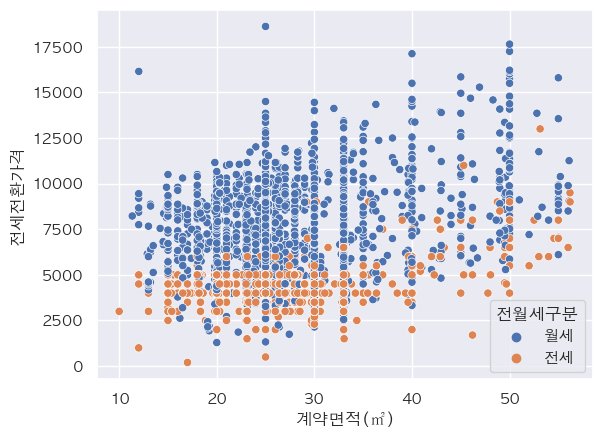

In [139]:
sns.scatterplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격", hue = "전월세구분")

<AxesSubplot:xlabel='계약년월', ylabel='전세전환가격'>

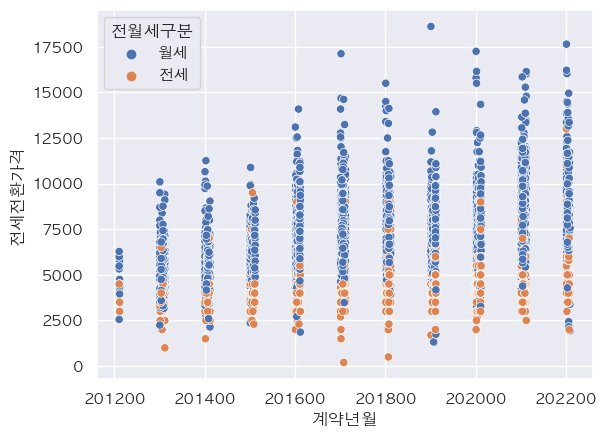

In [140]:
sns.scatterplot(data = gajwa, x = "계약년월", y = "전세전환가격", hue = "전월세구분")

<AxesSubplot:xlabel='건축년도', ylabel='전세전환가격'>

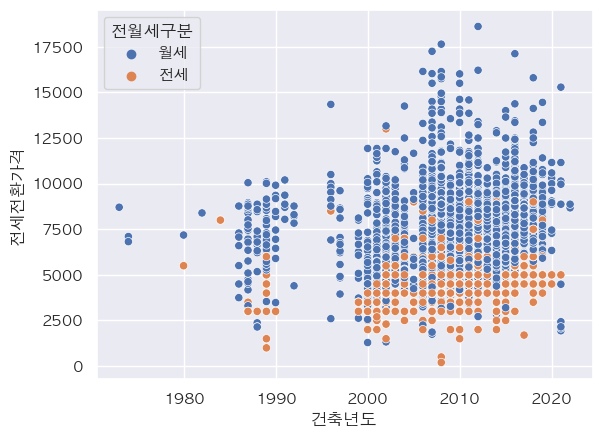

In [141]:
sns.scatterplot(data = gajwa, x = "건축년도", y = "전세전환가격", hue = "전월세구분")

In [142]:
# import folium

# m = folium.Map(location=[gnu_lat, gnu_long], zoom_start=16)

# for lo, la, in zip(gajwa.경도, gajwa.위도):
#     folium.Marker([la, lo]).add_to(m)

# m

In [143]:
# m = folium.Map(location=[gajwa.위도.max(),gajwa.경도.min()], zoom_start=16)
# folium.Marker([gajwa.위도.max(),gajwa.경도.min()]).add_to(m)
# m

In [144]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)

#원핫인코딩
gajwa = pd.get_dummies(gajwa, columns = ["도로조건"])
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])

gajwa

,시군구,번지,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,...,month,location,전월세전환율,전세전환가격,gnu_distance,도로조건_8,도로조건_12,도로조건_25,전월세구분_월세,전월세구분_전세
0,경상남도 진주시 가좌동,1***,12.00,201902,16,200,35,2016,가좌길74번길,128.105889,...,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356,0,0,1,1,0
1,경상남도 진주시 가좌동,1***,14.85,201902,20,500,35,2019,가좌길64번길,128.106121,...,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594,0,1,0,1,0
2,경상남도 진주시 가좌동,1***,16.00,201902,20,3000,0,2016,가좌길48번길,128.106188,...,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668,1,0,0,0,1
3,경상남도 진주시 가좌동,1***,18.00,201902,20,5000,0,2016,가좌길44번길,128.106188,...,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668,1,0,0,0,1
4,경상남도 진주시 가좌동,1***,18.00,201902,21,5000,0,2019,진주대로404번길,128.106188,...,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,경상남도 진주시 호탄동,6**,33.00,202011,16,1000,40,2016,호탄길34번길,128.102026,...,11,경상남도 진주시 호탄동 호탄길34번길,4.7,11213,0.440456,1,0,0,1,0
3668,경상남도 진주시 호탄동,6**,33.00,202011,19,100,23,2002,호탄길21번길,128.104882,...,11,경상남도 진주시 호탄동 호탄길21번길,4.7,5972,0.434847,0,1,0,1,0
3669,경상남도 진주시 호탄동,6**,42.90,202011,25,7500,0,2018,호탄길9번길,128.115149,...,11,경상남도 진주시 호탄동 호탄길9번길,4.7,7500,1.642123,1,0,0,0,1
3670,경상남도 진주시 호탄동,9**,50.00,202011,10,5000,30,2011,가호로61번길,128.103328,...,11,경상남도 진주시 호탄동 가호로61번길,4.7,12660,0.885957,0,1,0,1,0


In [145]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location", "경도", "위도", "전월세전환율", "gnu_distance"], axis=1)

#gajwa_data.distance = gajwa_data.distance.transform(lambda x: (x - x.mean()) / x.std())
#gajwa_data.전세전환가격 = gajwa_data.전세전환가격.transform(lambda x: (x - x.mean()) / x.std())
gajwa_data

,계약면적(㎡),건축년도,year,month,전세전환가격,도로조건_8,도로조건_12,도로조건_25,전월세구분_월세,전월세구분_전세
0,12.00,2016,2019,2,8435,0,0,1,1,0
1,14.85,2019,2019,2,8735,0,1,0,1,0
2,16.00,2016,2019,2,3000,1,0,0,0,1
3,18.00,2016,2019,2,5000,1,0,0,0,1
4,18.00,2019,2019,2,5000,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3667,33.00,2016,2020,11,11213,1,0,0,1,0
3668,33.00,2002,2020,11,5972,0,1,0,1,0
3669,42.90,2018,2020,11,7500,1,0,0,0,1
3670,50.00,2011,2020,11,12660,0,1,0,1,0


# 머신러닝

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [121]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [122]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [123]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [124]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [125]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [126]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [127]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
print(randomforest_model.score(X_test_standardized, y_test))

0.656966642760219
0.6475840855494523


In [128]:
gbm = GradientBoostingRegressor()

gbm.fit(X_train, y_train)
print(gbm.score(X_test, y_test))

gbm.fit(X_train_standardized, y_train)
print(gbm.score(X_test_standardized, y_test))

0.6525778420386182
0.6362325123945981


## LightGBM

In [129]:
lightgbm = lgb.LGBMRegressor()

lightgbm.fit(X_train, y_train)
print(lightgbm.score(X_test, y_test))

lightgbm.fit(X_train_standardized, y_train)
print(lightgbm.score(X_test_standardized, y_test))

0.6700351015302493
0.6592011106931237


## XGBoost

In [45]:
xgboost = XGBRegressor(n_estimators=50)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.7115374163796091


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.6976853237603458

## CatBoost

In [46]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train_standardized, y_train)
cb.score(X_test_standardized, y_test)

Learning rate set to 0.048441
0:	learn: 2383.2439257	total: 59.2ms	remaining: 59.1s
1:	learn: 2320.5804667	total: 59.9ms	remaining: 29.9s
2:	learn: 2265.7300686	total: 60.5ms	remaining: 20.1s
3:	learn: 2214.2419491	total: 61.1ms	remaining: 15.2s
4:	learn: 2163.8786940	total: 61.7ms	remaining: 12.3s
5:	learn: 2115.0130043	total: 62.3ms	remaining: 10.3s
6:	learn: 2068.6469894	total: 62.8ms	remaining: 8.91s
7:	learn: 2024.7551000	total: 63.3ms	remaining: 7.85s
8:	learn: 1985.9022363	total: 64ms	remaining: 7.05s
9:	learn: 1948.1275585	total: 64.6ms	remaining: 6.39s
10:	learn: 1912.7673314	total: 65.1ms	remaining: 5.85s
11:	learn: 1880.0693889	total: 65.6ms	remaining: 5.4s
12:	learn: 1849.3259021	total: 66.1ms	remaining: 5.02s
13:	learn: 1821.1380582	total: 66.7ms	remaining: 4.69s
14:	learn: 1795.1701962	total: 67.1ms	remaining: 4.41s
15:	learn: 1771.0869507	total: 67.6ms	remaining: 4.16s
16:	learn: 1747.2670587	total: 68.1ms	remaining: 3.94s
17:	learn: 1724.6264978	total: 68.7ms	remaining:

0.7224667996738534

In [47]:
gajwa_data.corr()

,계약면적(㎡),건축년도,year,month,전세전환가격,도로조건_8,도로조건_12,도로조건_25,전월세구분_월세,전월세구분_전세
계약면적(㎡),1.000000,-0.132891,-0.139559,0.070881,0.265486,0.065044,-0.093459,0.064589,0.050860,-0.050860
건축년도,-0.132891,1.000000,0.193912,0.002795,0.168735,-0.060891,0.078048,-0.037335,-0.021473,0.021473
year,-0.139559,0.193912,1.000000,-0.043369,0.350115,-0.253842,0.226361,0.086832,-0.024679,0.024679
month,0.070881,0.002795,-0.043369,1.000000,-0.013537,-0.035965,0.026134,0.026843,-0.043386,0.043386
전세전환가격,0.265486,0.168735,0.350115,-0.013537,1.000000,-0.227479,0.194079,0.099301,0.579035,-0.579035
도로조건_8,0.065044,-0.060891,-0.253842,-0.035965,-0.227479,1.000000,-0.919656,-0.273704,-0.046624,0.046624
도로조건_12,-0.093459,0.078048,0.226361,0.026134,0.194079,-0.919656,1.000000,-0.126013,0.027228,-0.027228
도로조건_25,0.064589,-0.037335,0.086832,0.026843,0.099301,-0.273704,-0.126013,1.000000,0.051090,-0.051090
전월세구분_월세,0.050860,-0.021473,-0.024679,-0.043386,0.579035,-0.046624,0.027228,0.051090,1.000000,-1.000000
전월세구분_전세,-0.050860,0.021473,0.024679,0.043386,-0.579035,0.046624,-0.027228,-0.051090,-1.000000,1.000000


## HyperParameter

In [ ]:
lightgbm.fit(X_train, y_train)
print(lightgbm.score(X_test, y_test))